In [1]:
import glob
import numpy as np
from PIL import Image
import imageio
from  matplotlib import pyplot as plt
%matplotlib inline

## reading images

In [2]:
imgs_dir = '../img/2/'
files = glob.glob(imgs_dir + 'in-*.*g')   # list of matching file paths
files = sorted(files)

imgs = [np.array(Image.open(files[i])) for i in range(len(files))]

factor = 0
shift = [imgs[0].shape[1] // (3 + factor)]*(len(imgs)-1)      # overlap range(hyper parameter)

## select the "best" image

In [3]:
def getBestImgIndex(imgs):
    best_index = 0
    best_value = 255
    for index, img in enumerate(imgs):
        current_mean = np.array([np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])])    # average for three channels
        diff = np.max(current_mean) - np.min(current_mean)  # difference of three channels
        if diff < best_value:       # choose the best(lowest)
            best_index = index
            best_value = diff
    return best_index
best_img_index = getBestImgIndex(imgs)

## color correction

In [4]:
def colorCorrection(images_temp, shift, bestIndex, gamma=2.2):      # set gamma to 2.2 by paper
    alpha = np.ones((3, len(images_temp)))

    # compute light averages in the overlap area by linearizing the gamma-corrected RGB values
    for rightBorder in range(bestIndex+1, len(images_temp)):
        for i in range(bestIndex+1, rightBorder+1):
            I = images_temp[i]
            J = images_temp[i-1]
            overlap = I.shape[1] - shift[i-1]
            for channel in range(3):
                alpha[channel, i] = np.sum(np.power(J[:,-overlap-1:,channel], gamma))/np.sum(np.power(I[:,0:overlap+1,channel],gamma))  # derivative

        G = np.sum(alpha, 1)/np.sum(np.square(alpha), 1)
        
        for i in range(bestIndex+1, rightBorder+1):
            for channel in range(3):
                images_temp[i][:,:,channel] = np.power(G[channel] * alpha[channel, i], 1.0/gamma) * images_temp[i][:,:,channel]     # perform using correction coefficients and the global adjustment
                
    for leftBorder in range(bestIndex-1, -1, -1):
        for i in range(bestIndex-1, leftBorder-1, -1):
            I = images_temp[i]
            J = images_temp[i+1]
            overlap = I.shape[1] - shift[i-1]
            for channel in range(3):
                alpha[channel, i] = np.sum(np.power(J[:,0:overlap+1,channel], gamma))/np.sum(np.power(I[:,-overlap-1:,channel],gamma))

        G = np.sum(alpha, 1)/np.sum(np.square(alpha), 1)
        
        for i in range(bestIndex-1, leftBorder-1, -1):
            for channel in range(3):
                images_temp[i][:,:,channel] = np.power(G[channel] * alpha[channel, i], 1.0/gamma) * images_temp[i][:,:,channel]
    return images_temp

imgs_corrected = colorCorrection(imgs, shift, best_img_index)
# imgs_corrected = imgs

## optimal seam finding

In [5]:
def calcErrorSurface(panorama, curr_img, overlap, channel):
    left = panorama[:, -overlap-1:, channel]
    right = curr_img[:, 0:overlap+1, channel]
    return np.square(left - right)

In [6]:
def calcSeam(e):
    E = np.zeros(e.shape)   # cumulative minimum squared difference
    E[0,:] = e[0,:]
    # dynamic programming
    for h in range(1, e.shape[0]):
        for w in range(0, e.shape[1]):
            if w == 0:
                cost = min(E[h-1, w], E[h-1, w+1])
            elif w == e.shape[1]-1:
                cost = min(E[h-1, w-1], E[h-1, w])
            else:
                cost = min(E[h-1, w-1], E[h-1, w], E[h-1, w+1])
            E[h,w] = e[h,w] + cost
    return E

In [7]:
def calcSeamPath(E, e):
    h = e.shape[0]
    path = np.zeros((h, 1))
    idx = np.argmin(E[h-1, :])
    path[h-1] = idx
    for h in range(e.shape[0]-2,-1,-1):     # tracking back the paths with a minimal cost from bottom to top
        w = int(path[h+1][0])
        if w > 0 and E[h, w-1] == E[h+1, w]-e[h+1, w]:
            path[h] = w-1
        elif w < e.shape[1] - 1 and E[h, w+1] == E[h+1, w]-e[h+1, w]:
            path[h] = w+1
        else:
            path[h] = w

    path[path==0] = 1
    return path

In [8]:
def stitchImage(panorama, curr_img, path, overlap):
    n = 1
    bound_threshold = 15    # poisson blending threshold(hyper parameter)
    
    tmp = np.zeros((0,panorama.shape[1] + curr_img.shape[1] - overlap,3)).astype('float64')
    for h in range(0, panorama.shape[0]):
        A = np.expand_dims(panorama[h, 0:-(overlap-int(path[h][0])+1), :], axis=0)
        B = np.expand_dims(curr_img[h, int(path[h][0])-1:, :], axis = 0)
        
        # deriveration
        ZA = np.concatenate((np.expand_dims(panorama[h,:,:],axis=0), np.zeros((A.shape[0],panorama.shape[1] + curr_img.shape[1] - overlap-np.expand_dims(panorama[h,:,:],axis=0).shape[1],3))), axis=1)
        ZB = np.concatenate((np.expand_dims(panorama[h,0:panorama.shape[1] + curr_img.shape[1] - overlap-np.expand_dims(curr_img[h,:,:],axis=0).shape[1],:], axis=0), np.expand_dims(curr_img[h,:,:],axis=0)), axis=1)

        filter_A = np.ones((1, A.shape[1]-bound_threshold))
        grad = np.expand_dims(np.linspace(1, 0, 2*bound_threshold+1, endpoint=True), axis = 0)
        filter_B = np.zeros((1, B.shape[1]-bound_threshold))
        blender = np.concatenate((filter_A, grad, filter_B), axis=1)
        Z = (blender[:, 0:ZA.shape[1]].T*ZA.T).T + ((1-blender[:, 0:ZB.shape[1]]).T*ZB.T).T

        tmp = np.concatenate((tmp,Z))
    return tmp

# main

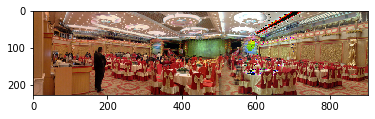

In [9]:
panorama = imgs_corrected[0]
for i in range(1, len(imgs_corrected)):
    curr_img = imgs_corrected[i]
    channel = np.argmax([np.var(curr_img[:,:,0]), np.var(curr_img[:,:,1]), np.var(curr_img[:,:,2])])       # get the channel with the largest mean variance

    overlap = curr_img.shape[1] - shift[i-1]

    error_surface = calcErrorSurface(panorama, curr_img, overlap, channel)

    E = calcSeam(error_surface)

    path = calcSeamPath(E, error_surface)

    panorama = stitchImage(panorama, curr_img, path, overlap)

result = np.array(255*panorama/np.max(panorama)).astype('uint8')
plt.figure()
plt.imshow(result)
imageio.imwrite(imgs_dir+'output.png', np.array(255*panorama/np.max(panorama)).astype('uint8'))